In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import string 
import itertools
from collections import Counter
import os
import re
from os import path
from wordcloud import WordCloud
from PIL import Image
import numpy as np

In [2]:
corpus = pd.read_csv('data/raw/guardian_environment.csv')

col_of_interest = ['id', 'webPublicationDate', 'fields_publication', 'fields_byline',
                   'fields_headline', 'fields_standfirst', 'fields_body', 'fields_bodyText',
                   'fields_wordcount', 'fields_charCount']
# select columns of interest
corpus = corpus.loc[:, col_of_interest]
# convert 'webPublicationDate' field to year
corpus['webPublicationDate'] = pd.to_datetime(corpus['webPublicationDate']).dt.year
# rename columns
new_colnames = {'webPublicationDate': 'year', 'fields_publication': 'where', 'fields_byline': 'author',
                'fields_headline': 'headline', 'fields_standfirst': 'standfirst', 'fields_body': 'body', 'fields_bodyText':'bodyText',
                'fields_wordcount': 'wordcount', 'fields_charCount': 'charcount'}
corpus.rename(columns=new_colnames, inplace=True)

corpus = corpus[corpus['bodyText'].isna() == False]

corpus['headline'][corpus['headline'].isna() == True] = ''
corpus['standfirst'][corpus['standfirst'].isna() == True] = ''

with open('data/guardian_environment/info.json', 'r') as f:
    info = json.load(f)
    vocab = info['vocab_tr']
    corpus = corpus.iloc[info['indices_tr'], :]
    docs_bow = [[vocab[v] for v in doc] for doc in info['docs_tr']]
    del info

In [3]:
corpus

,id,year,where,author,headline,standfirst,body,bodyText,wordcount,charcount
7811,environment/2020/dec/27/reasons-to-be-hopeful,2020,The Observer,"Patrick Barkham, Richard Godwin, Amelia Tait a...",Reasons to be hopeful in 2021,"<p>2020 has been a difficult year, but there a...",<h2><strong>A vaccine for HIV: ‘This is an inc...,A vaccine for HIV: ‘This is an incredibly exci...,3993,24401
4854,environment/2017/apr/28/temperature-boosting-e...,2017,theguardian.com,"Damian Carrington, environment editor",Temperature-boosting El Niño set for early ret...,<p>The climate event that helped supercharge g...,<p>The El Niño climate event that helped super...,The El Niño climate event that helped supercha...,574,3491
4678,environment/2017/jan/31/more-than-100-natural-...,2017,theguardian.com,Michael Slezak,More than 100 natural world heritage sites deg...,<p>Forest loss worst in North America and Aust...,<p>More than 100 of the world’s most precious ...,More than 100 of the world’s most precious nat...,549,3458
4329,environment/2016/sep/27/climate-chief-uk-mustn...,2016,theguardian.com,Severin Carrell Scotland editor,Climate chief: UK must not use Brexit to water...,<p>Committee on Climate Change adaptation comm...,<p>The UK must not water down its environmenta...,The UK must not water down its environmental l...,780,4898
977,environment/planet-oz/2013/dec/12/climate-chan...,2013,theguardian.com,Graham Readfearn,Awesome fossil fuel burning is defying the pas...,More fossil fuel projects approved in Australi...,<p>We're doing some pretty awesome things here...,We're doing some pretty awesome things here in...,836,4782
...,...,...,...,...,...,...,...,...,...,...
4791,environment/2017/mar/29/ray-collier-obituary,2017,The Guardian,Martin Wainwright,Ray Collier obituary,Country Diarist who adopted the wilds of Scotl...,"<p>Ray Collier, who has died aged 79, was devo...","Ray Collier, who has died aged 79, was devoted...",692,4154
4483,environment/2016/nov/17/we-have-been-almost-bu...,2016,theguardian.com,"Hannah McNeish in El Damer, Sudan",'We have been almost buried': the Sudanese vil...,<p>Climate change and deforestation mean peopl...,<p>Standing next to a thin belt of rattling tr...,Standing next to a thin belt of rattling trees...,966,5750
6054,environment/2018/nov/14/crab-fishermen-sue-oil...,2018,theguardian.com,Erin McCormick in San Francisco,Claws out: crab fishermen sue 30 oil firms ove...,<p>Fossil fuel companies including Chevron and...,<p>For the fourth-generation crab fisherman Jo...,For the fourth-generation crab fisherman John ...,940,5696
6967,environment/2019/nov/02/thousands-britons-invi...,2019,The Guardian,Fiona Harvey Environment correspondent,Thousands of Britons invited to climate crisis...,"<p>Only 110 of 30,000 who receive invitations ...",<p>Thirty-thousand people across the UK have b...,Thirty-thousand people across the UK have been...,622,3744


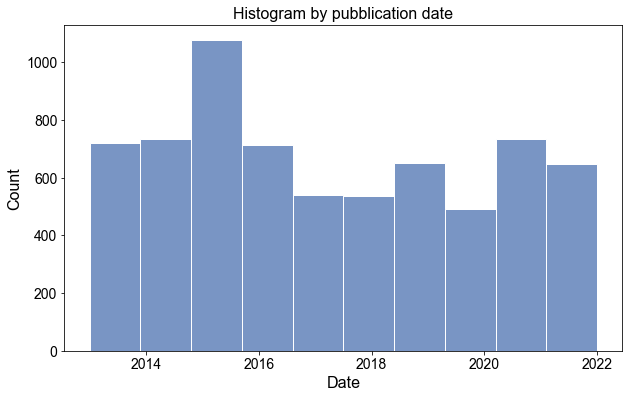

In [4]:
fig, ax = plt.subplots(figsize = (10,6))
plt.rcParams['font.size'] = '14'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
    
sns.set(style = "darkgrid")
sns.histplot(data = corpus, x = "year", bins = 10).set
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.title('Histogram by pubblication date', fontsize = 16)
plt.show()

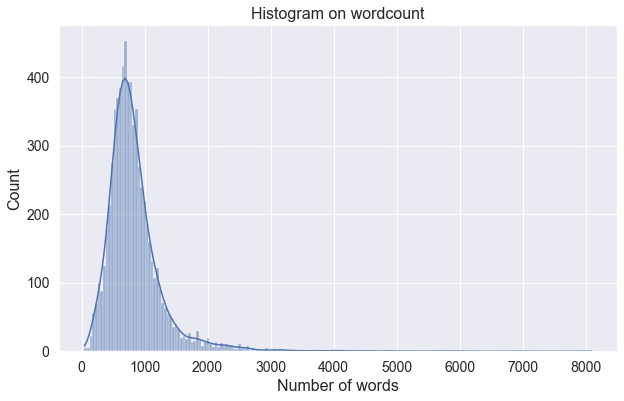

In [5]:
fig, ax = plt.subplots(figsize = (10,6))
plt.rcParams['font.size'] = '14'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
    
sns.set(style = "darkgrid")
sns.histplot(data = corpus, x = "wordcount", kde = True)
plt.xlabel('Number of words', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.title('Histogram on wordcount', fontsize = 16)
plt.show()

Documents with more than 3000 words is 51


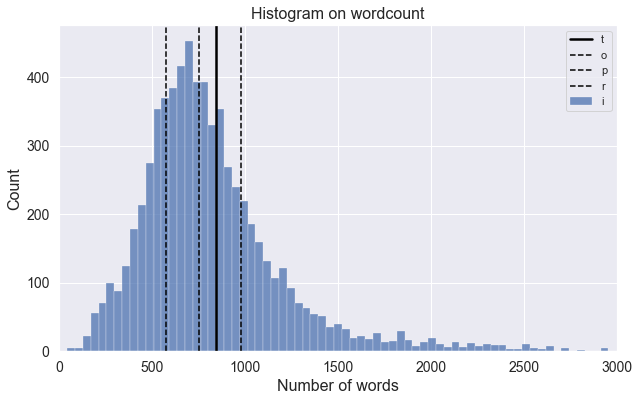

In [42]:
l = ['mean', '1st quartiles','median','3rd quartile','histogram']

fig, ax = plt.subplots(figsize = (10,6))
plt.rcParams['font.size'] = '14'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
    
print('Documents with more than 3000 words is '+str(len(corpus[corpus["wordcount"] >= 3000])))
sns.set(style = "darkgrid")
sns.histplot(data = corpus, x = 'wordcount')
plt.xlabel('Number of words', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.title('Histogram on wordcount', fontsize = 16)
plt.xlim(0,3000)
plt.axvline(np.mean(corpus['wordcount']), linewidth = 2.5, color = 'black')
plt.axvline(np.percentile(corpus['wordcount'], 25), linestyle = '--', color='black')
plt.axvline(np.percentile(corpus['wordcount'], 50), linestyle = '--', color='black')
plt.axvline(np.percentile(corpus['wordcount'], 75), linestyle = '--', color='black')
plt.legend('topright')
plt.show()

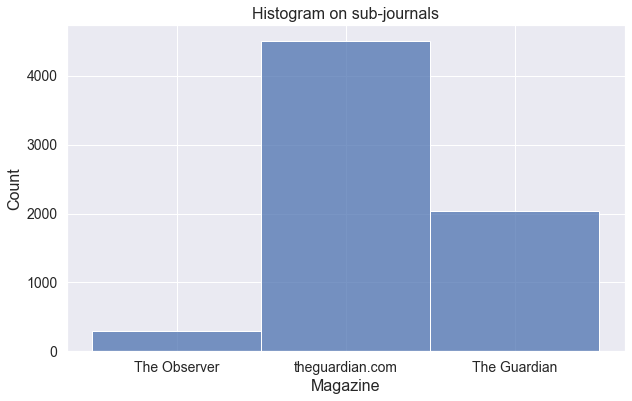

In [7]:
fig, ax = plt.subplots(figsize = (10,6))
plt.rcParams['font.size'] = '14'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
    
sns.set(style="darkgrid")
sns.histplot(data=corpus, x="where")
plt.xlabel('Magazine', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.title('Histogram on sub-journals', fontsize = 16)
plt.show()

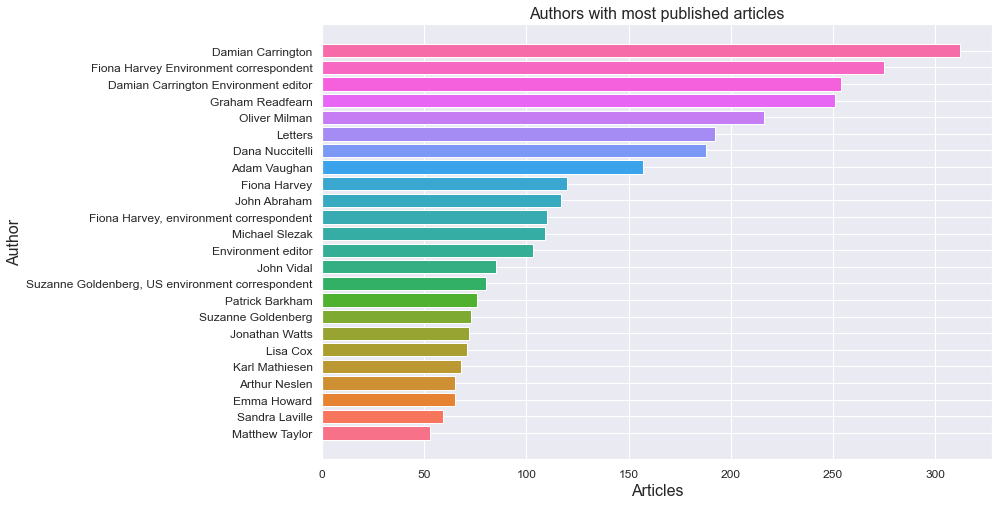

In [8]:
absolute_frequencies = dict()
for author in corpus['author']:
    if author in absolute_frequencies.keys():
        absolute_frequencies[author] += 1
    else:
        absolute_frequencies[author] = 1

absolute_frequencies_2 = {}
for key, value in absolute_frequencies.items():
    if value >= 50:
        absolute_frequencies_2[key] = value
        
absolute_frequencies_2.pop(np.nan, None) # 91 articles have unkown authors.  
    
absolute_frequencies_2

ind = np.arange(len(absolute_frequencies_2))
palette = sns.color_palette("husl", len(absolute_frequencies_2))
absolute_frequencies_3 = dict(sorted(absolute_frequencies_2.items(), key = lambda item: item[1]))

fig, ax = plt.subplots(figsize = (12,8))
plt.rcParams['font.size'] = '12'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)

plt.barh(ind, list(absolute_frequencies_3.values()), color = palette, align = 'center')
plt.yticks(ind, list(absolute_frequencies_3.keys()))
ax.set_ylabel('Author', fontsize = 16)
ax.set_xlabel('Articles', fontsize = 16)
ax.set_title('Authors with most published articles', fontsize = 16)
plt.show()

In [9]:
docs_bowf = [item for sublist in docs_bow for item in sublist]
docs_bowf_count = Counter(docs_bowf)

tot_dwords = {}
tot_dword = dict(sorted(docs_bowf_count.items(), key = lambda item: item[1]))

tot_dword

{'negligible': 24,
 'gamechanger': 25,
 'haven': 26,
 'outweighed': 26,
 'adjusted': 27,
 'sunk': 27,
 'paused': 29,
 'abruptly': 29,
 'proportions': 29,
 'cooperate': 29,
 'excuses': 30,
 'employers': 30,
 'insistence': 30,
 'jurisdictions': 30,
 'threeyear': 31,
 'nafeez': 31,
 'positioned': 32,
 'treasure': 32,
 'premise': 32,
 'gigantic': 32,
 'underpin': 32,
 'wrecking': 32,
 'impressed': 32,
 'dominance': 32,
 'upgrades': 32,
 'eager': 32,
 'illnesses': 32,
 'embark': 32,
 'equation': 32,
 'crumbling': 32,
 'colossal': 33,
 'collaborative': 33,
 'grateful': 33,
 'tail': 33,
 'evolving': 33,
 'horrible': 33,
 'belongs': 33,
 'unintended': 33,
 'impoverished': 33,
 'float': 33,
 'nervous': 33,
 'acquired': 34,
 'vibrant': 34,
 'fairer': 34,
 'bust': 34,
 'user': 34,
 'behave': 34,
 'assisted': 34,
 'proximity': 34,
 'cultures': 34,
 'cascading': 34,
 'enhancing': 34,
 'expanse': 34,
 'circles': 34,
 'nonexistent': 34,
 'cares': 34,
 'erratic': 34,
 'suits': 34,
 'weird': 34,
 'subj

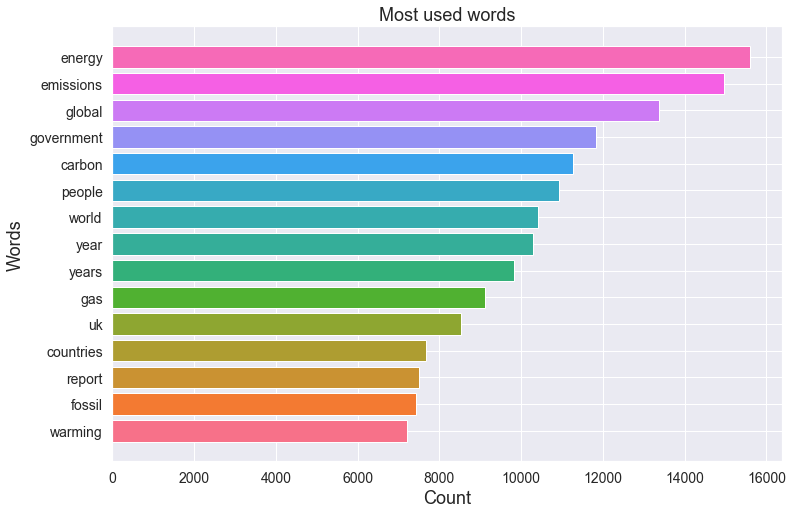

In [10]:
num_best_words = 15
best_tot_dwords = dict(sorted(tot_dword.items(), key = lambda item: item[1], reverse = True)[:num_best_words])

ind = np.arange(len(best_tot_dwords))
palette = sns.color_palette("husl", len(best_tot_dwords))
best_tot_dwords_2 = dict(sorted(best_tot_dwords.items(), key=lambda item: item[1]))

fig, ax = plt.subplots(figsize = (12,8))
plt.rcParams['font.size'] = '14'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
    
plt.barh(ind, list(best_tot_dwords_2.values()) , color=palette, align = 'center')
plt.yticks(ind, list(best_tot_dwords_2.keys()))
ax.set_ylabel('Words', fontsize = 18)
ax.set_xlabel('Count', fontsize = 18)
ax.set_title('Most used words', fontsize = 18)
plt.show()

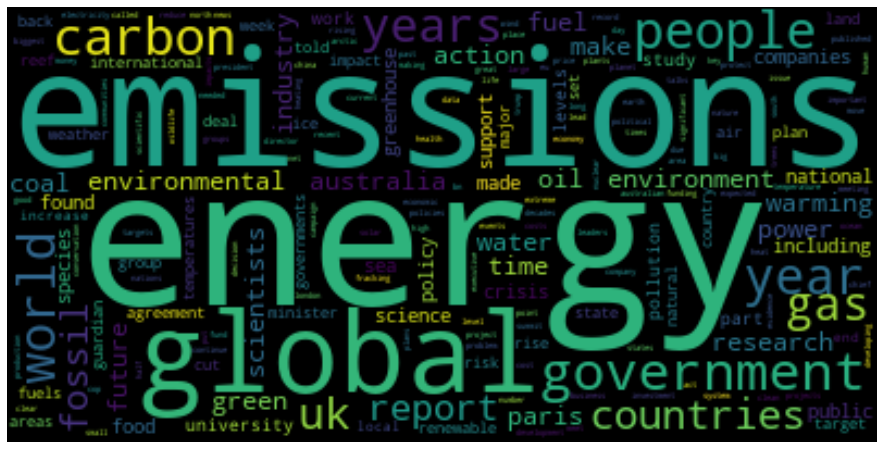

In [11]:
wordcloud = WordCloud().generate_from_frequencies(tot_dword)

fig, ax = plt.subplots(figsize = (20,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

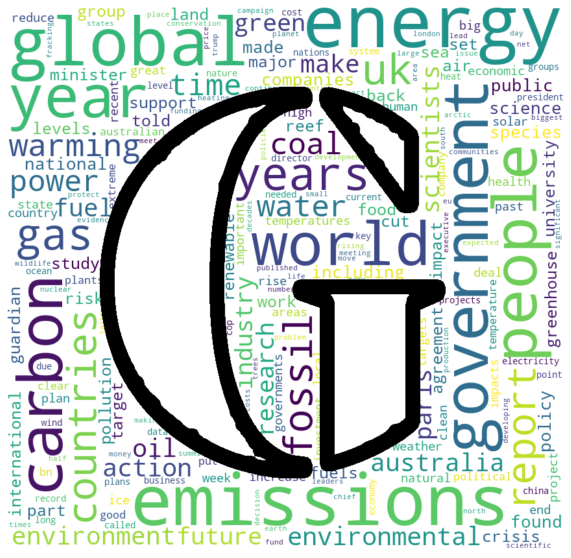

In [12]:
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

guardian_mask = np.array(Image.open(path.join(d, "guardian.png")))

wc = WordCloud(background_color="white", mask = guardian_mask, contour_width = 45, contour_color = 'black').generate_from_frequencies(tot_dword)
# show
fig, ax = plt.subplots(figsize = (10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [13]:
timestamps = [str(y) for y in corpus['year']]
timestamps
len(timestamps)

docs_by_year = {}
for year in sorted(list(set(timestamps))):
    docs_by_year[year] = [docs_bow[d] for d in range(len(docs_bow)) if timestamps[d]==year]

In [19]:
def get_wordcloud(year):
    docs_bowf_year = [item for sublist in docs_by_year[str(year)] for item in sublist]
    docs_bowf_count_year = Counter(docs_bowf_year)

    tot_dwords_year = {}
    tot_dword_year = dict(sorted(docs_bowf_count_year.items(), key = lambda item: item[1]))

    wordcloud = WordCloud().generate_from_frequencies(tot_dword_year)

    fig, ax = plt.subplots(figsize = (20,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

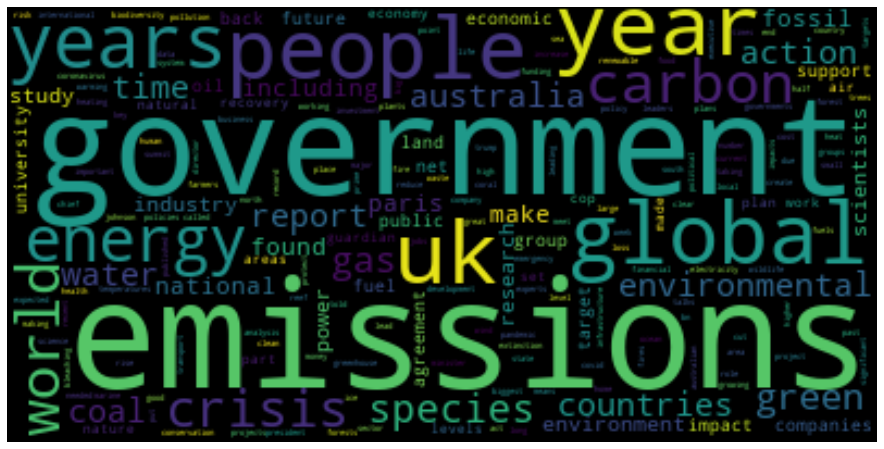

In [20]:
get_wordcloud(2020)